In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-05-17 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Corona-Hub von www.npgeo.de](https://npgeo-corona-npgeo-de.hub.arcgis.com/)
    * [RKI COVID19](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0)
    * [CSV](https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv)
    * [Robert Koch-Institut: COVID-19-Dashboard](https://npgeo-corona-npgeo-de.hub.arcgis.com/app/478220a4c454480e823b17327b2bf1d4)
* [Priesemann-Group/covid19_inference_forecast](https://github.com/Priesemann-Group/covid19_inference_forecast/commit/4d34d342cd8e58c18b5107ce38c537d4e83bc561)
    * [data_retrieval.py](https://github.com/Priesemann-Group/covid19_inference_forecast/blob/master/covid19_inference/data_retrieval.py)

* [data source description](https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74)

* [DRP Austria Covid-19 Hub](https://covid-19-drp-austria.hub.arcgis.com/)
    * [Dashboard](https://experience.arcgis.com/experience/fb603473e1f74f0bbae48155ff238565)
    * [Daten](https://covid-19-drp-austria.hub.arcgis.com/search?categories=covid-19)
        * [COVID19 VERLAUF BUNDESLAND](https://covid-19-drp-austria.hub.arcgis.com/datasets/covid19-verlauf-bundesland?orderBy=genesene&orderByAsc=false)
    * [data.gv.at](https://www.data.gv.at/covid-19/)

In [5]:
df = covid19.get_rki_df()
cbr_germany = covid19.CasesByRegion('Germany', df=df)
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-12,172697,153380,7633,532,0,123
2020-05-13,173268,153380,7732,571,0,99
2020-05-14,173749,153380,7812,481,0,80
2020-05-15,174124,153380,7895,375,0,83
2020-05-16,174321,153379,7935,197,-1,40


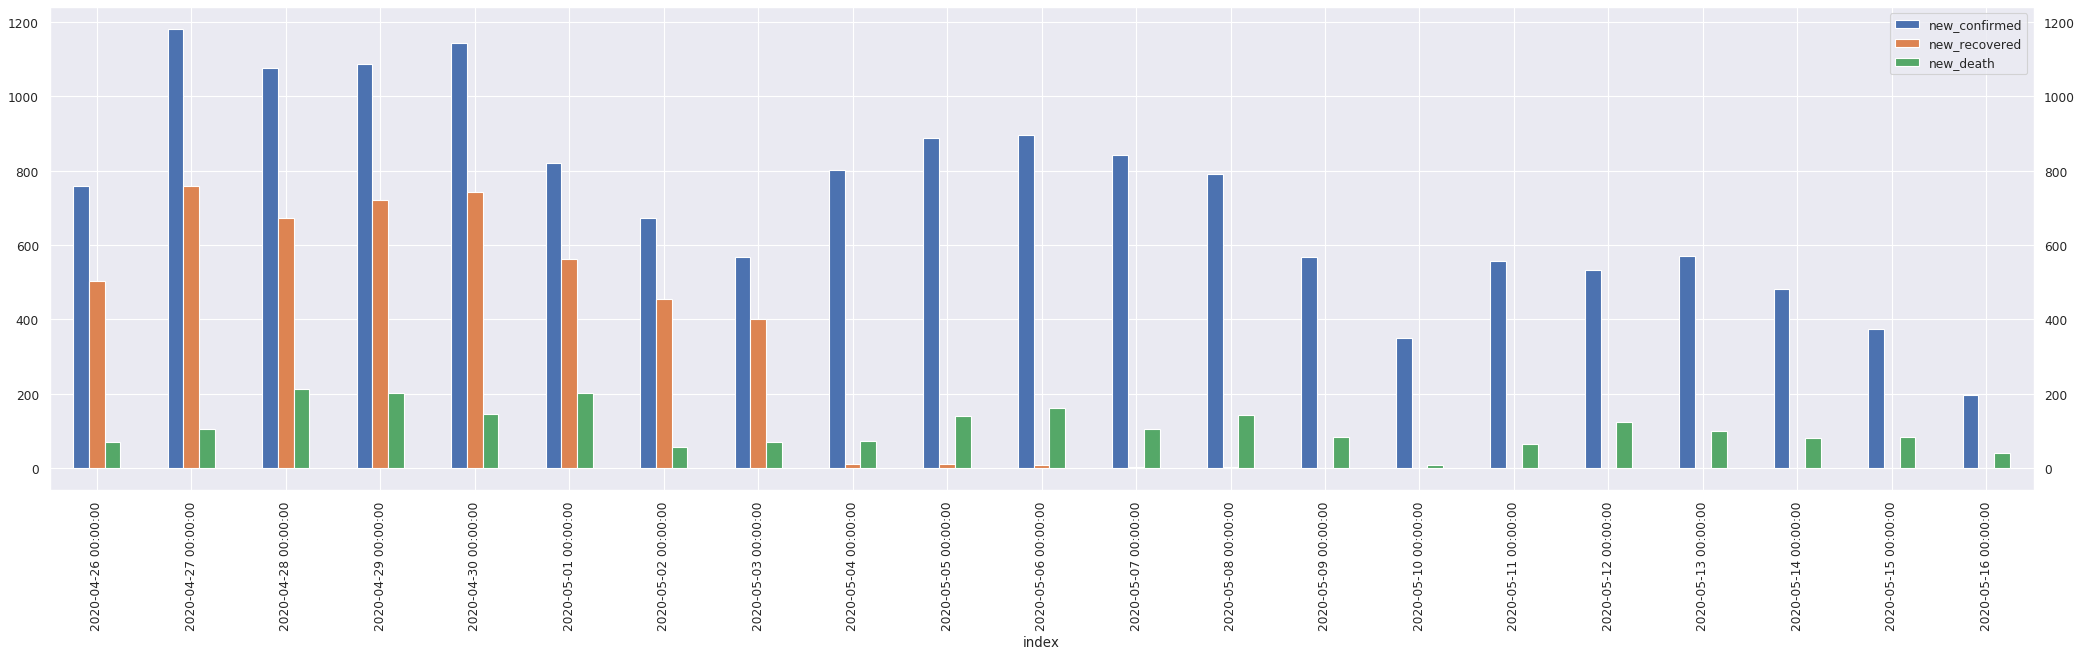

In [6]:
cbr_germany.plot_daily_stats()

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 432.5548085829899, max asymptotic: 179372.4001148294; growth-rate: 0.002, date:2020-06-08 00:00:00, projected value: 91.98520542638457


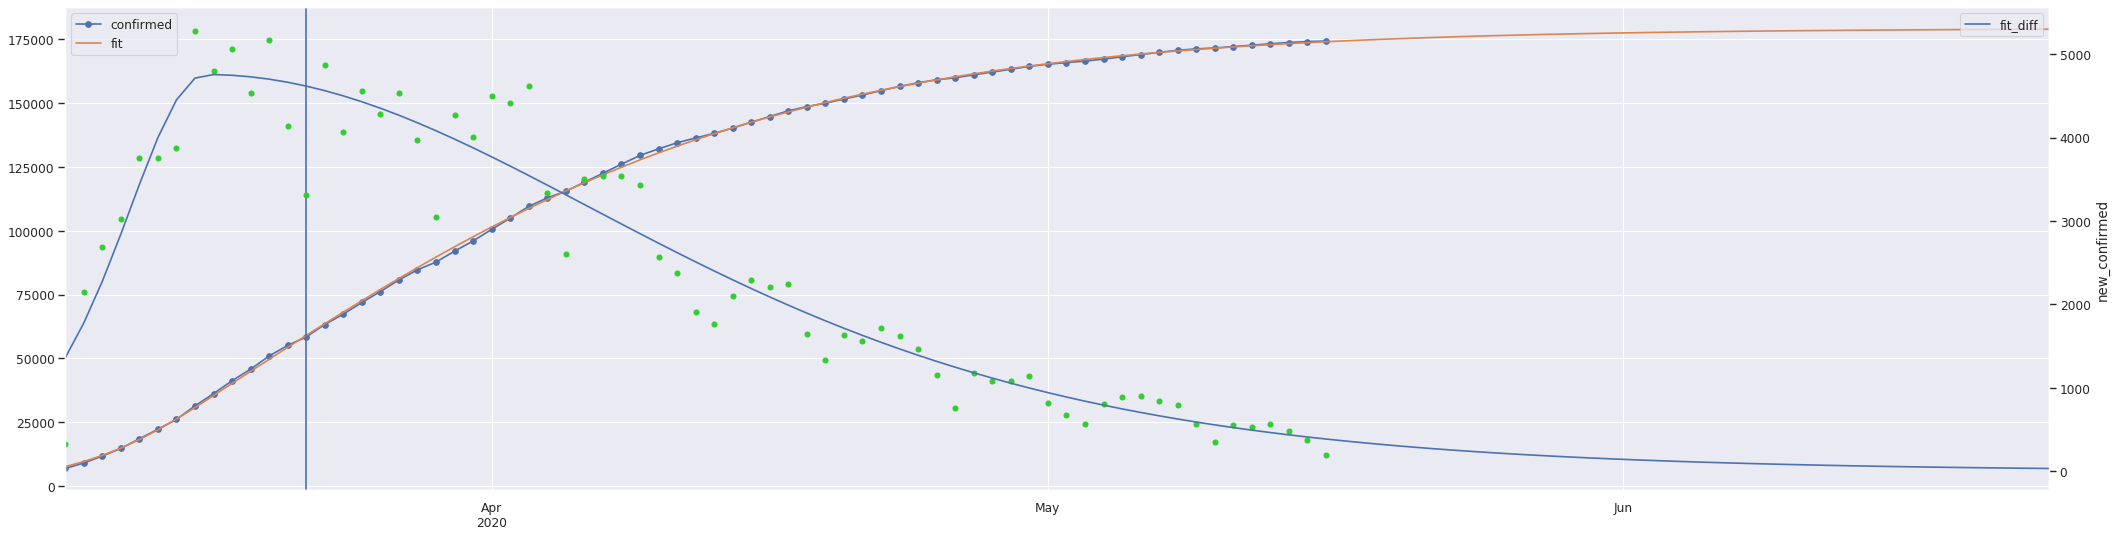

In [7]:
cbr_germany.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [8]:
# country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
# ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, in_df=cbr_germany.df, first_date=first_date, init_add=init_add)
# if len(lpopt) == 4:
#     steady_state_rate = lpopt[1] * lpopt[3]
# else:
#     steady_state_rate = 0.0
# print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
# fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
# ax = plt.subplot(1,1,1)
# ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
# ax.axvline(restriction_start_date);

# ax2 = ax.twinx()
# ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
# lbl = 'confirmed' + '_diff'
# ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


# l = len(ax.get_yticks())
# a1 = ax.get_yticks()[0]
# e1 = ax.get_yticks()[-1]
# a2 = ax2.get_yticks()[0]
# e2 = ax2.get_yticks()[-1]
# ax.set_yticks(np.linspace(a1, e1, l));
# ax2.set_yticks(np.linspace(a2, e2, l));

In [9]:
cbr_germany.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,4754.609753


In [10]:
cbr_germany.calculate_R_estimates()
cbr_germany.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-14,0.592,0.537,0.404,0.49,0.54


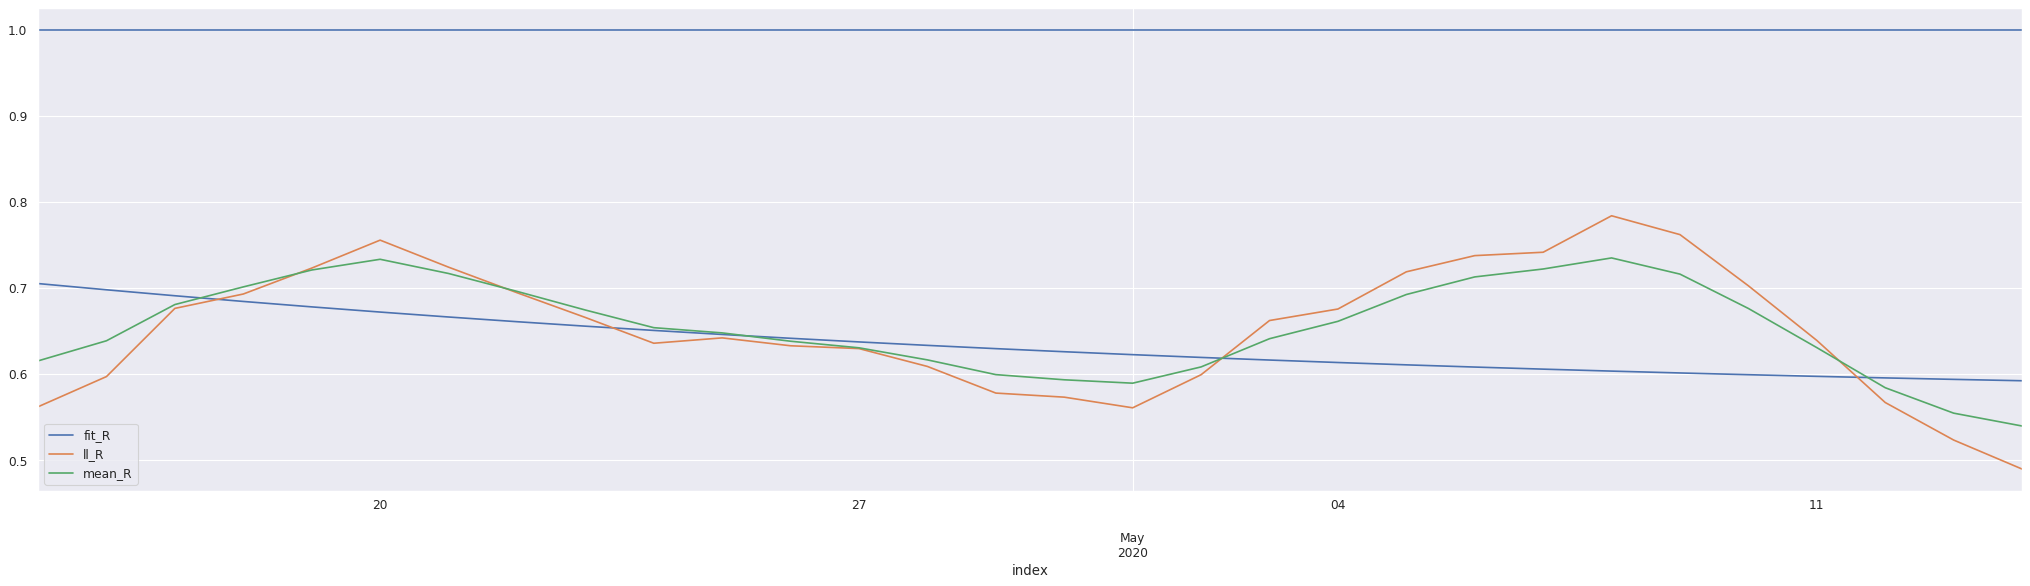

In [11]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [12]:
# --------------------------------------------------------------------------------------------------------------------------------



# --------------------------------------------------------------------------------------------------------------------------------

In [13]:
df = covid19.get_rki_df(state='Bayern')
cbr_bavaria = covid19.CasesByRegion('Bavaria', df=df)
cbr_bavaria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-12,45041,39900,2278,151,0,0
2020-05-13,45157,39900,2281,116,0,3
2020-05-14,45288,39900,2282,131,0,1
2020-05-15,45376,39900,2283,88,0,1
2020-05-16,45420,39899,2283,44,-1,0


In [14]:
einwohner_deutschland = 83019213.0
einwohner_bayern      = 13076721.0
prozent_bayern        = einwohner_bayern / einwohner_deutschland

bavaria_new_confirmed_threshold = (100.0 * prozent_bayern) // 1 + 1
bavaria_new_confirmed_threshold

16.0

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 129.8321335960545, max asymptotic: 46011.24227960434; growth-rate: 0.002, date:2020-06-07 00:00:00, projected value: 13.868808868960627


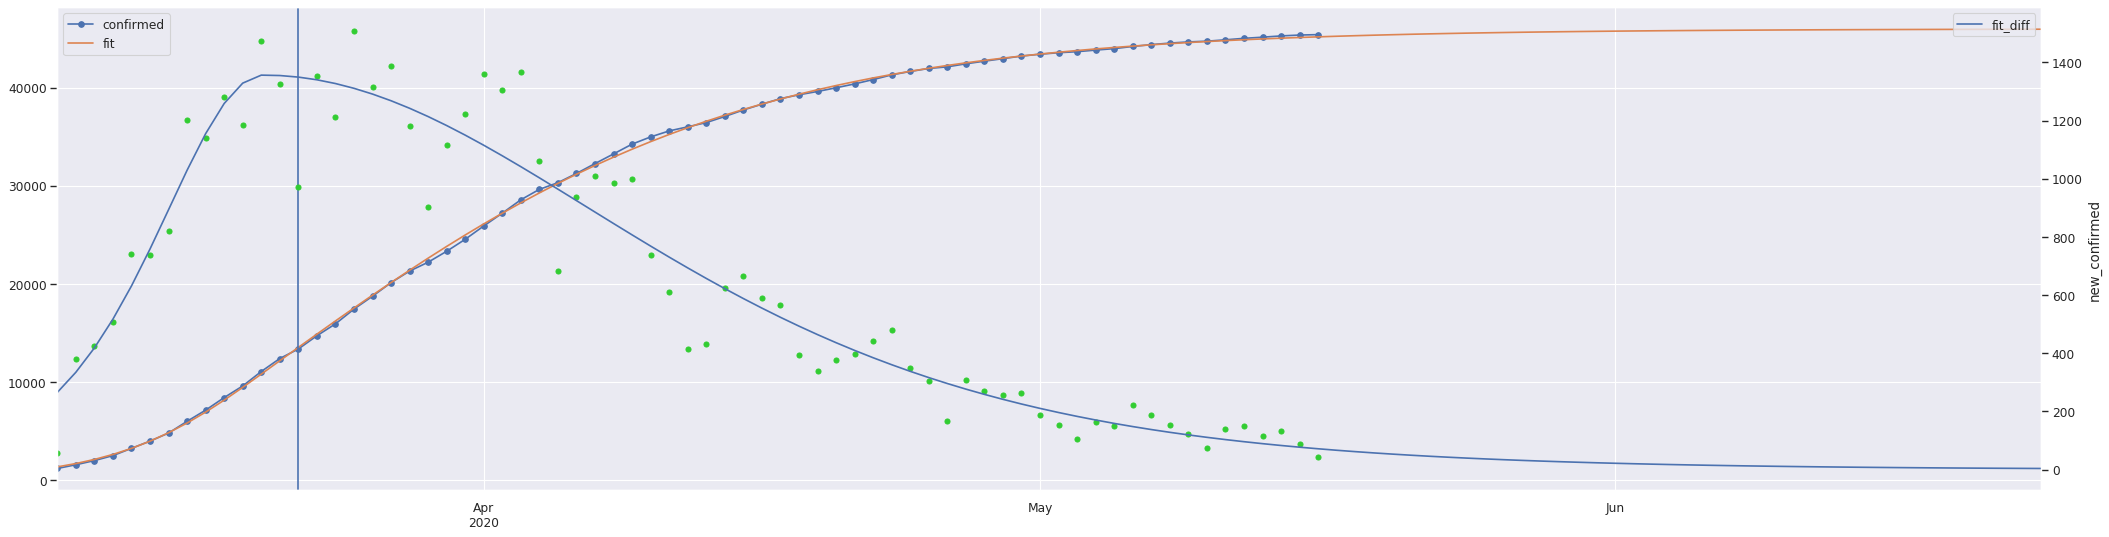

In [15]:
cbr_bavaria.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=bavaria_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bavaria.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [16]:
cbr_bavaria.calculate_R_estimates()
cbr_bavaria.R().round(3)

,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-14,0.511,0.766,0.527,0.651,0.643


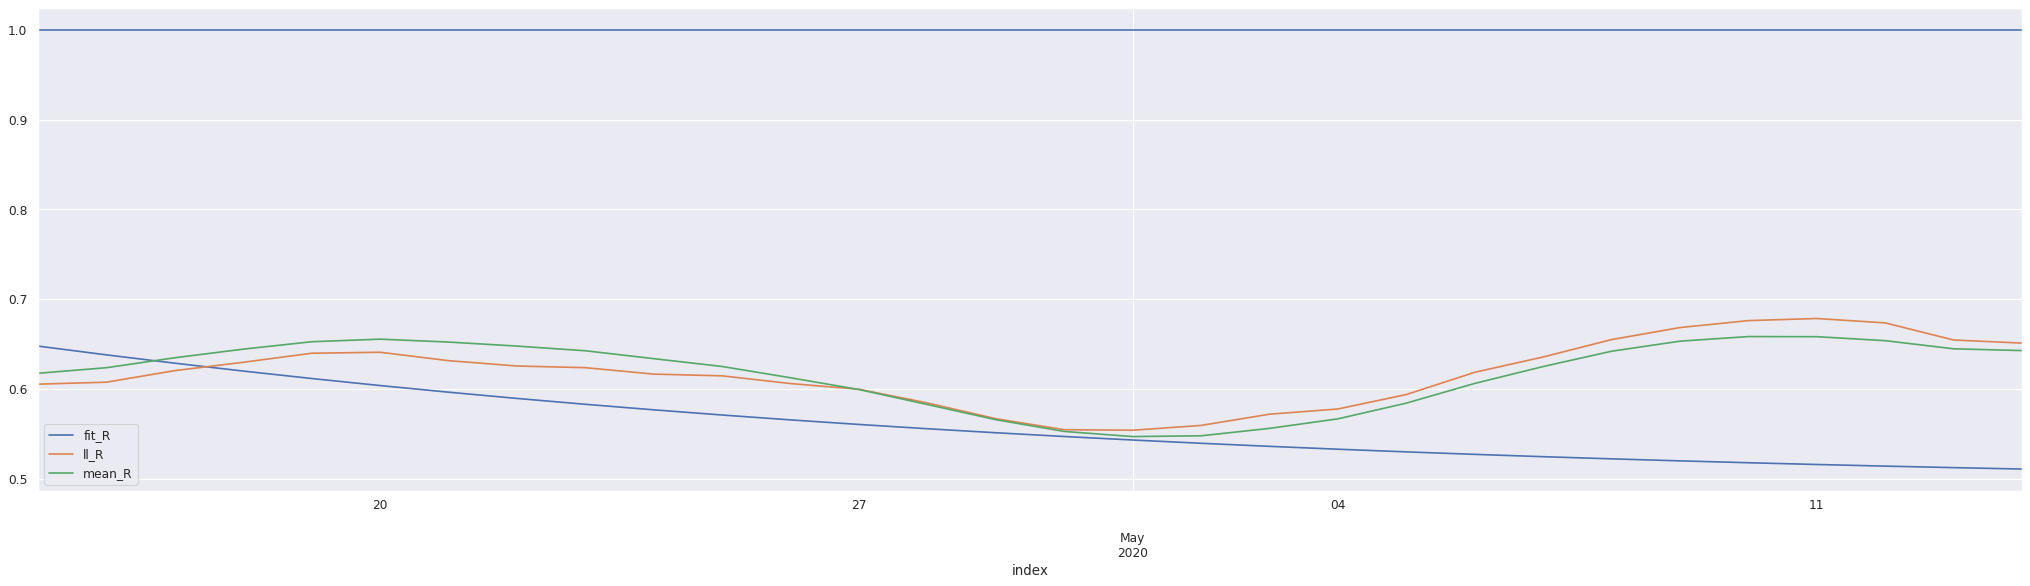

In [17]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bavaria.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [18]:
df = covid19.get_rki_df(state='Nordrhein-Westfalen')
cbr_nrw = covid19.CasesByRegion('NRW', df=df)
cbr_nrw.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-12,35800,31910,1503,138,0,0
2020-05-13,35940,31910,1503,140,0,0
2020-05-14,36064,31910,1503,124,0,0
2020-05-15,36190,31910,1504,126,0,1
2020-05-16,36277,31910,1504,87,0,0


In [19]:
einwohner_nrw      = 17932651.0
prozent_nrw        = einwohner_nrw / einwohner_deutschland

nrw_new_confirmed_threshold = (100.0 * prozent_nrw) // 1 + 1
nrw_new_confirmed_threshold

22.0

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 98.92117910683533, max asymptotic: 37452.371826660434; growth-rate: 0.003, date:2020-06-12 00:00:00, projected value: 20.71193549391579


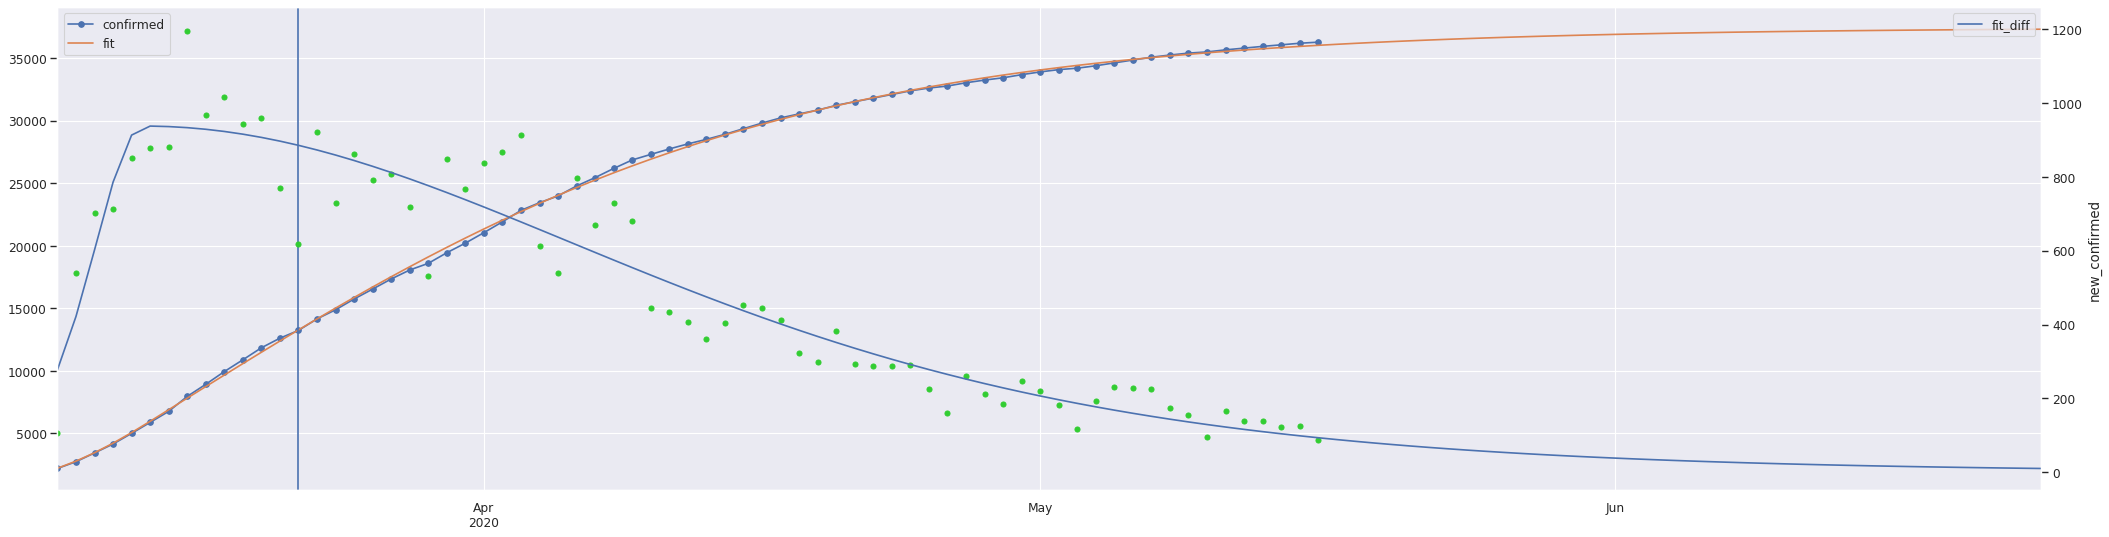

In [20]:
cbr_nrw.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=nrw_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_nrw.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [21]:
cbr_nrw.calculate_R_estimates()
cbr_nrw.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-14,0.636,0.563,0.355,0.487,0.562


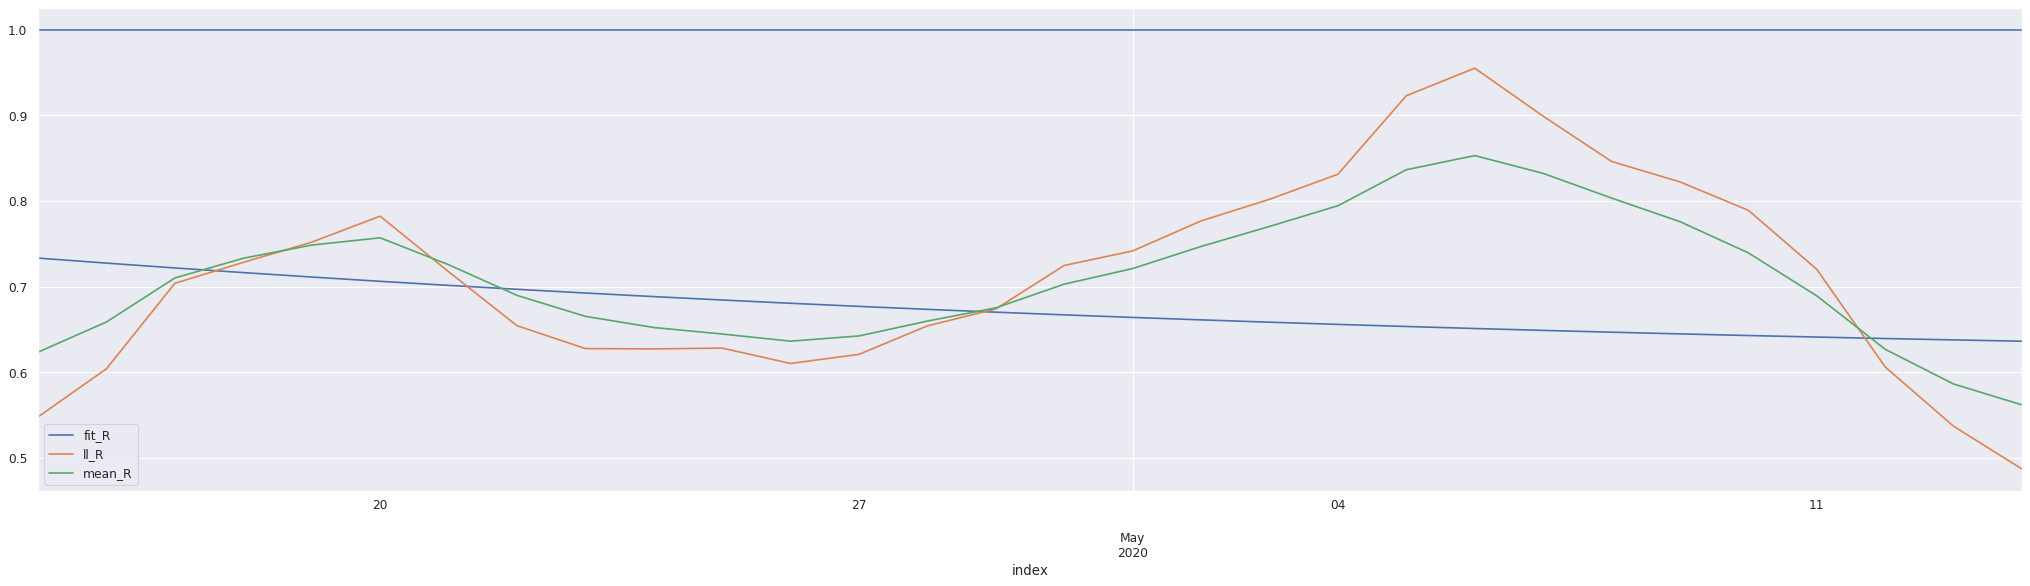

In [22]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_nrw.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [23]:
covid19.rki_data_df.Bundesland.unique()

array(['Schleswig-Holstein', 'Hamburg', 'Niedersachsen', 'Bremen', 'Nordrhein-Westfalen', 'Hessen', 'Rheinland-Pfalz', 'Baden-Württemberg', 'Bayern', 'Saarland', 'Berlin', 'Brandenburg', 'Mecklenburg-Vorpommern', 'Sachsen', 'Sachsen-Anhalt', 'Thüringen'], dtype=object)

In [24]:
df = covid19.get_rki_df(state='Baden-W')
cbr_bw = covid19.CasesByRegion('BW', df=df)
cbr_bw.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-12,33721,29976,1646,66,0,1
2020-05-13,33817,29976,1647,96,0,1
2020-05-14,33884,29976,1648,67,0,1
2020-05-15,33929,29976,1648,45,0,0
2020-05-16,33949,29976,1648,20,0,0


In [25]:
einwohner_bw      = 11069533.0
prozent_bw        = einwohner_bw / einwohner_deutschland

bw_new_confirmed_threshold = (100.0 * prozent_bw) // 1 + 1
bw_new_confirmed_threshold

14.0

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 89.47767335193912, max asymptotic: 34908.48860198596; growth-rate: 0.002, date:2020-06-10 00:00:00, projected value: 12.417392025119739


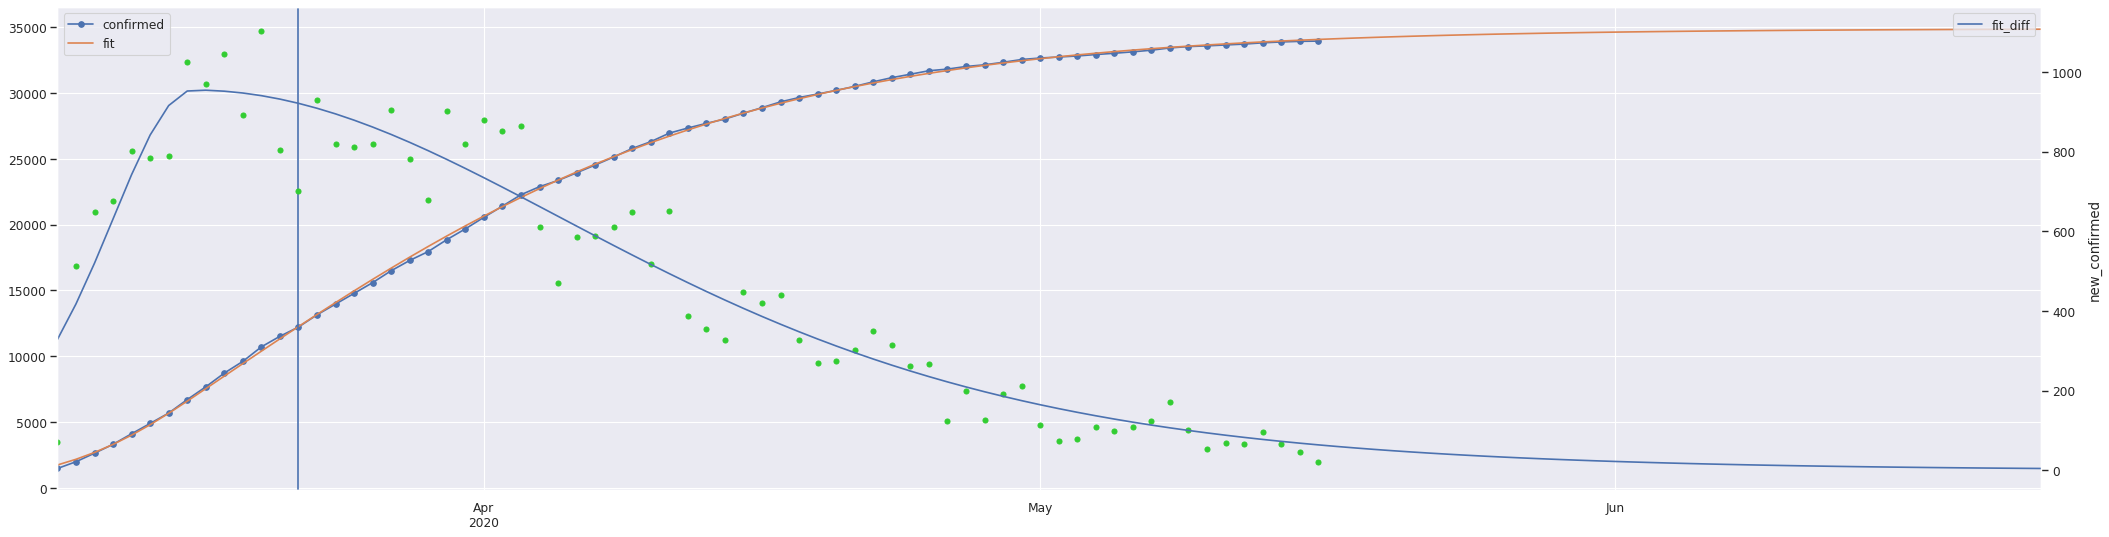

In [26]:
cbr_bw.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=bw_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bw.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [27]:
cbr_bw.calculate_R_estimates()
cbr_bw.R().round(3)

,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-14,0.57,0.594,0.484,0.549,0.571


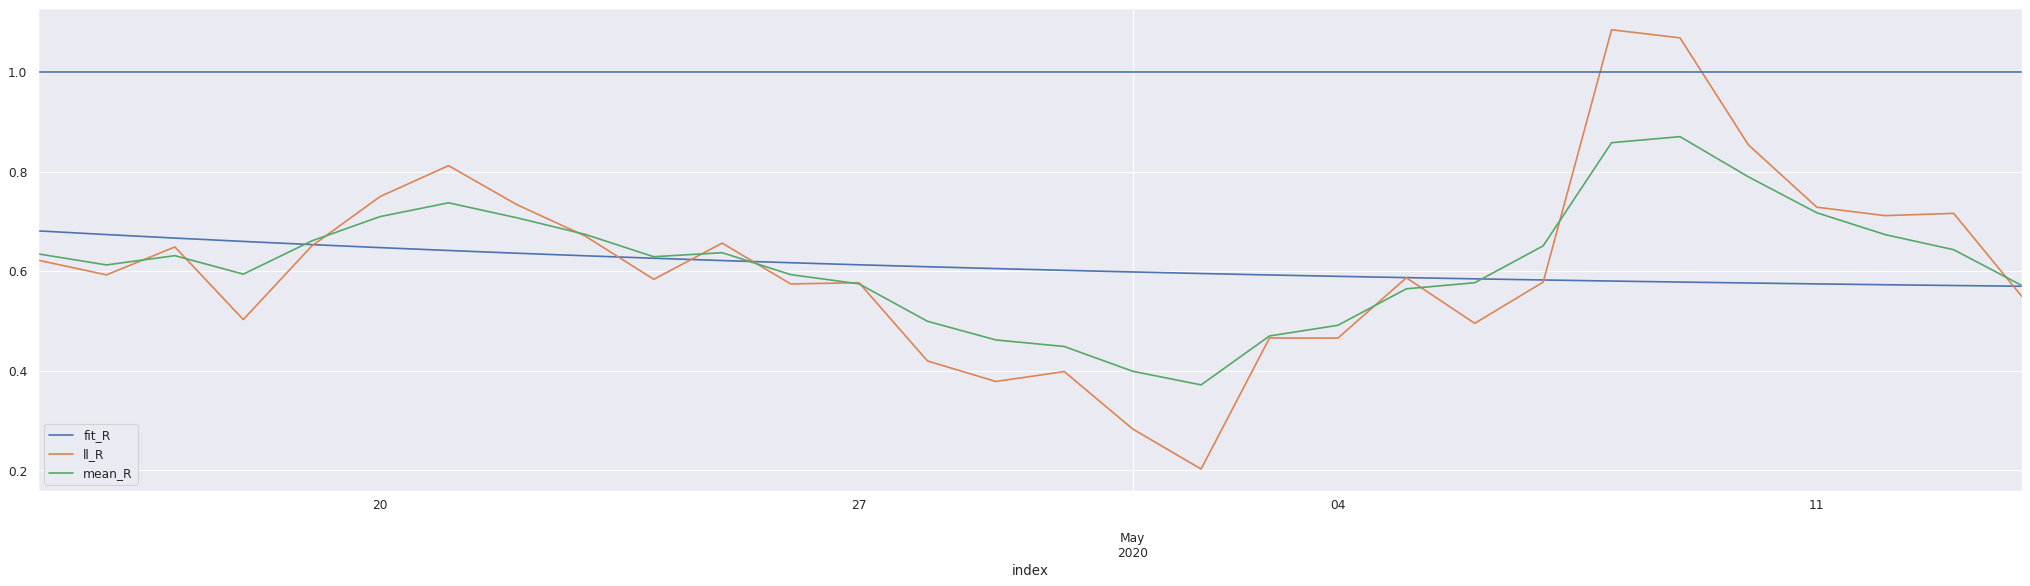

In [28]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_bw.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [29]:
df = covid19.get_rki_df(county='LK Traunstein')
cbr_traunstein = covid19.CasesByRegion('LK Traunstein', df=df)
cbr_traunstein.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-12,1262,1075,84,1,0,0
2020-05-13,1265,1075,84,3,0,0
2020-05-14,1267,1075,84,2,0,0
2020-05-15,1268,1075,84,1,0,0
2020-05-16,1268,1075,84,0,0,0


In [30]:
tage_inzidenz = 10

In [31]:
# https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/04-kreise.html
einwohner_lk_traunstein = 177089
einwohner_sk_regensburg = 152610
einwohner_lk_regensburg = 193572

In [32]:
tage_inzidenz_lk_traunstein = cbr_traunstein.df['new_confirmed'][-tage_inzidenz:].sum() 
round(tage_inzidenz_lk_traunstein,1), round(tage_inzidenz_lk_traunstein / einwohner_lk_traunstein / tage_inzidenz  * 100000,1), round(tage_inzidenz_lk_traunstein / einwohner_lk_traunstein / tage_inzidenz  * 100000 * 7,1)

(29, 1.6, 11.5)

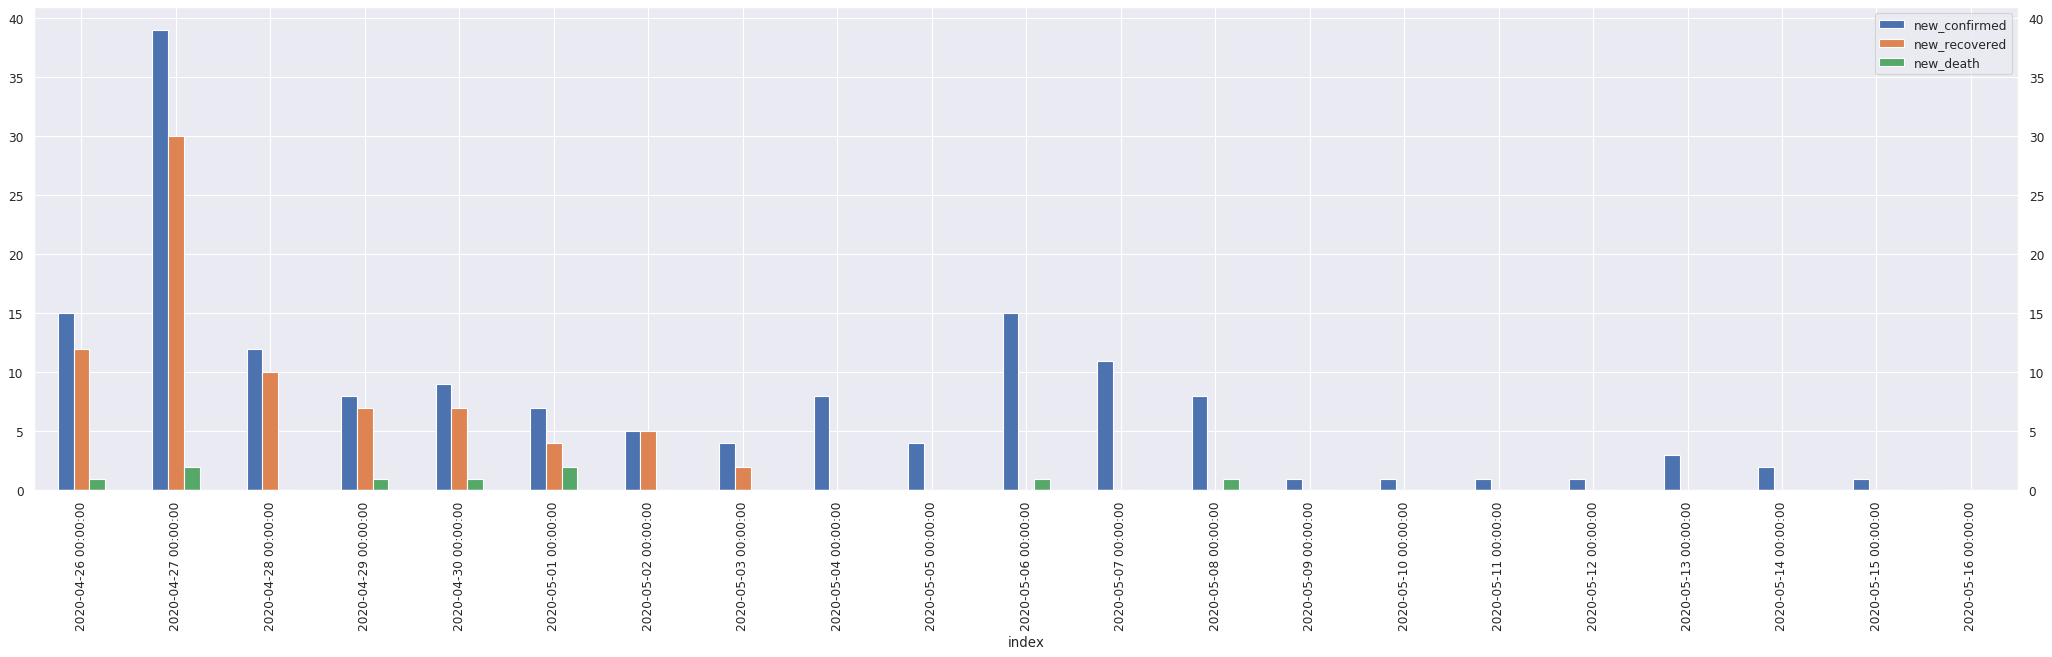

In [33]:
cbr_traunstein.plot_daily_stats()

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 7.287995531904237, max asymptotic: 1405.8594787931129; growth-rate: 0.005, date:2020-06-24 00:00:00, projected value: 0.6283162184786253


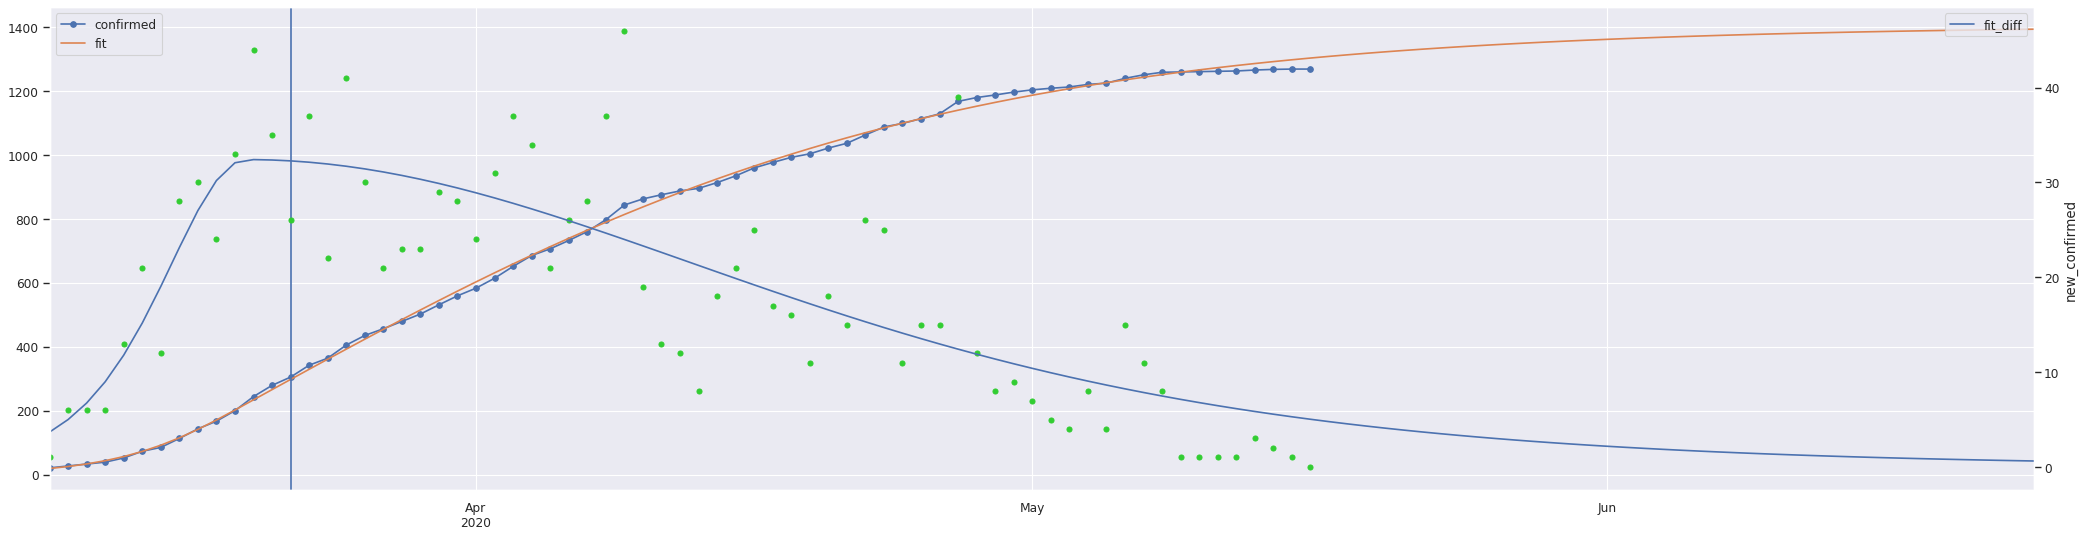

In [34]:
cbr_traunstein.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_traunstein.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [35]:
cbr_traunstein.calculate_R_estimates()
cbr_traunstein.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-14,0.664,0.321,0.0,0.108,0.364


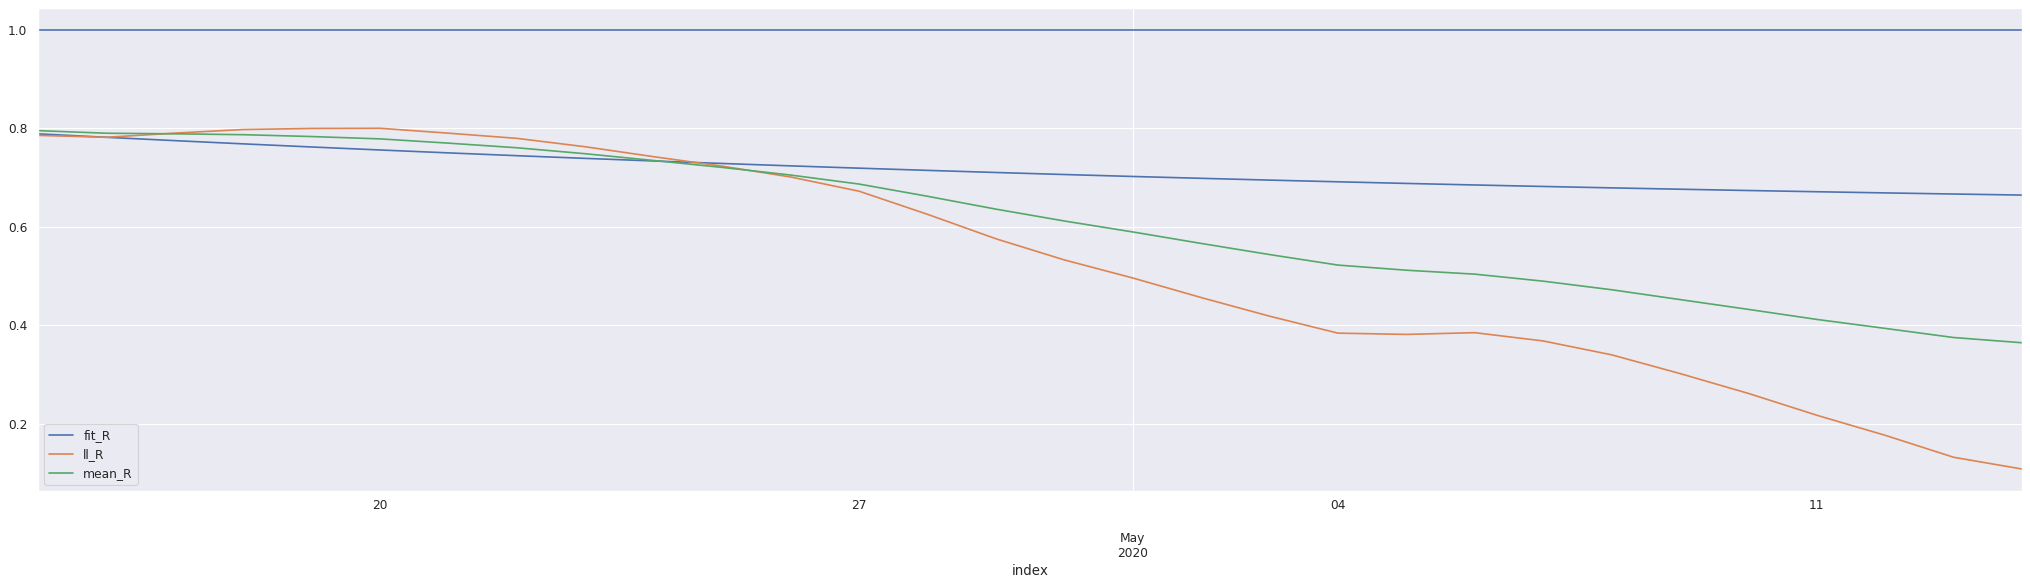

In [36]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_traunstein.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [37]:
df = covid19.get_rki_df(county='SK Regensburg')
cbr_sk_regensburg = covid19.CasesByRegion('SK Regensburg', df=df)
cbr_sk_regensburg.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-12,481,439,9,1,0,0
2020-05-13,482,439,9,1,0,0
2020-05-14,487,439,9,5,0,0
2020-05-15,487,439,9,0,0,0
2020-05-16,487,439,9,0,0,0


In [38]:
tage_inzidenz_sk_regensburg = cbr_sk_regensburg.df['new_confirmed'][-tage_inzidenz:].sum()
round(tage_inzidenz_sk_regensburg,1), round(tage_inzidenz_sk_regensburg / einwohner_sk_regensburg / tage_inzidenz * 100000, 1), round(tage_inzidenz_sk_regensburg / einwohner_sk_regensburg / tage_inzidenz * 100000 * 7, 1)

(12, 0.8, 5.5)

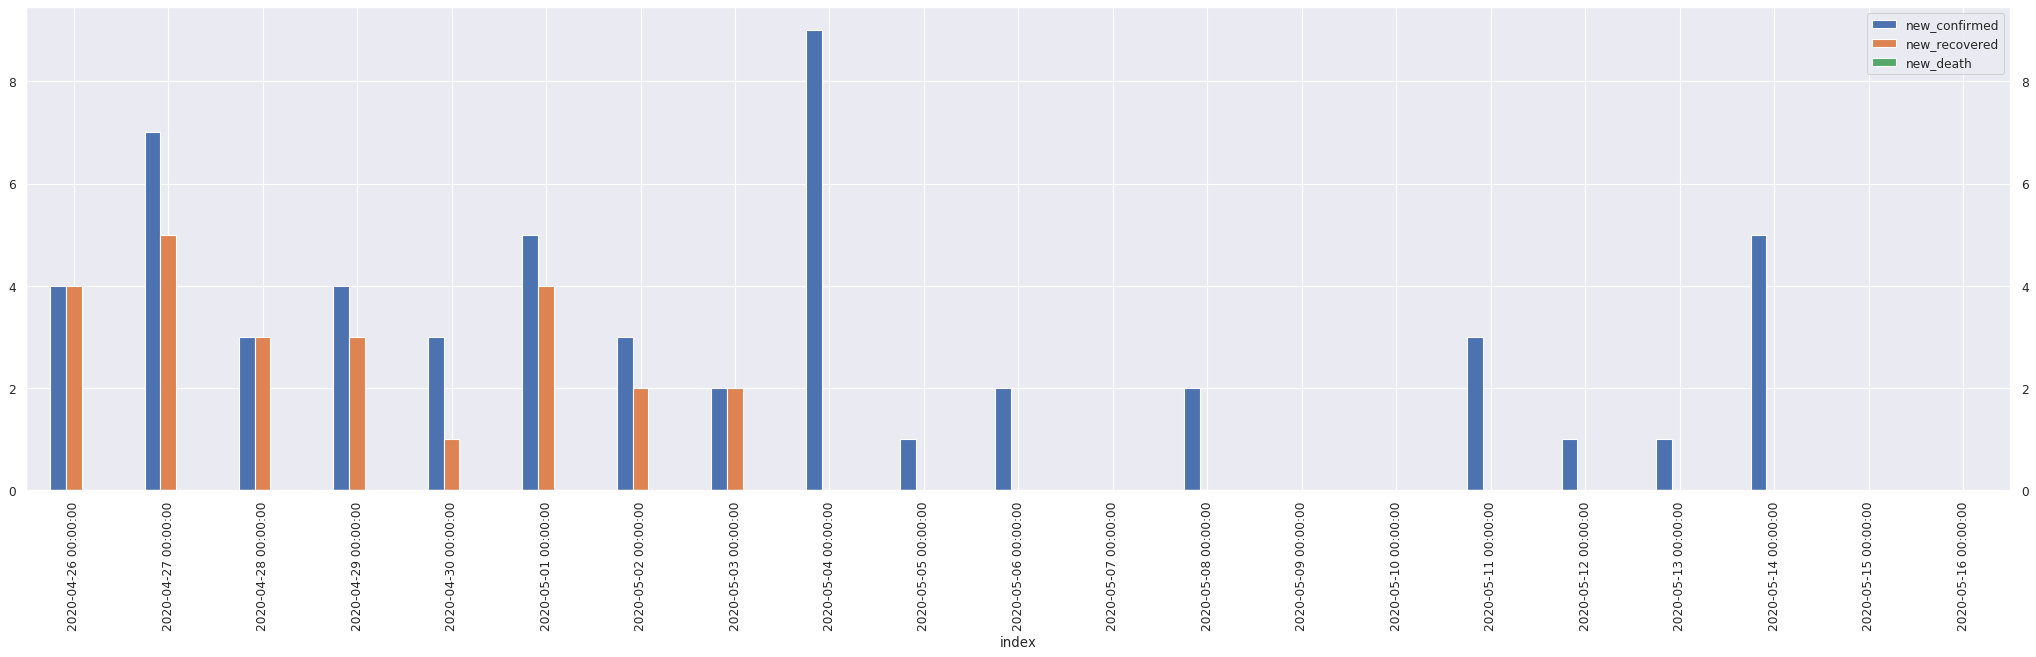

In [39]:
cbr_sk_regensburg.plot_daily_stats()

In [40]:
df = covid19.get_rki_df(county='LK Regensburg')
cbr_lk_regensburg = covid19.CasesByRegion('LK Regensburg', df=df)
cbr_lk_regensburg.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-12,445,414,14,0,0,0
2020-05-13,445,414,14,0,0,0
2020-05-14,447,414,14,2,0,0
2020-05-15,447,414,14,0,0,0
2020-05-16,447,414,14,0,0,0


In [41]:
tage_inzidenz_lk_regensburg = cbr_lk_regensburg.df['new_confirmed'][-tage_inzidenz:].sum()
tage_inzidenz_lk_regensburg, round(tage_inzidenz_lk_regensburg / einwohner_lk_regensburg / tage_inzidenz * 100000, 1), round(tage_inzidenz_lk_regensburg / einwohner_lk_regensburg / tage_inzidenz * 100000 * 7, 1)

(10, 0.5, 3.6)

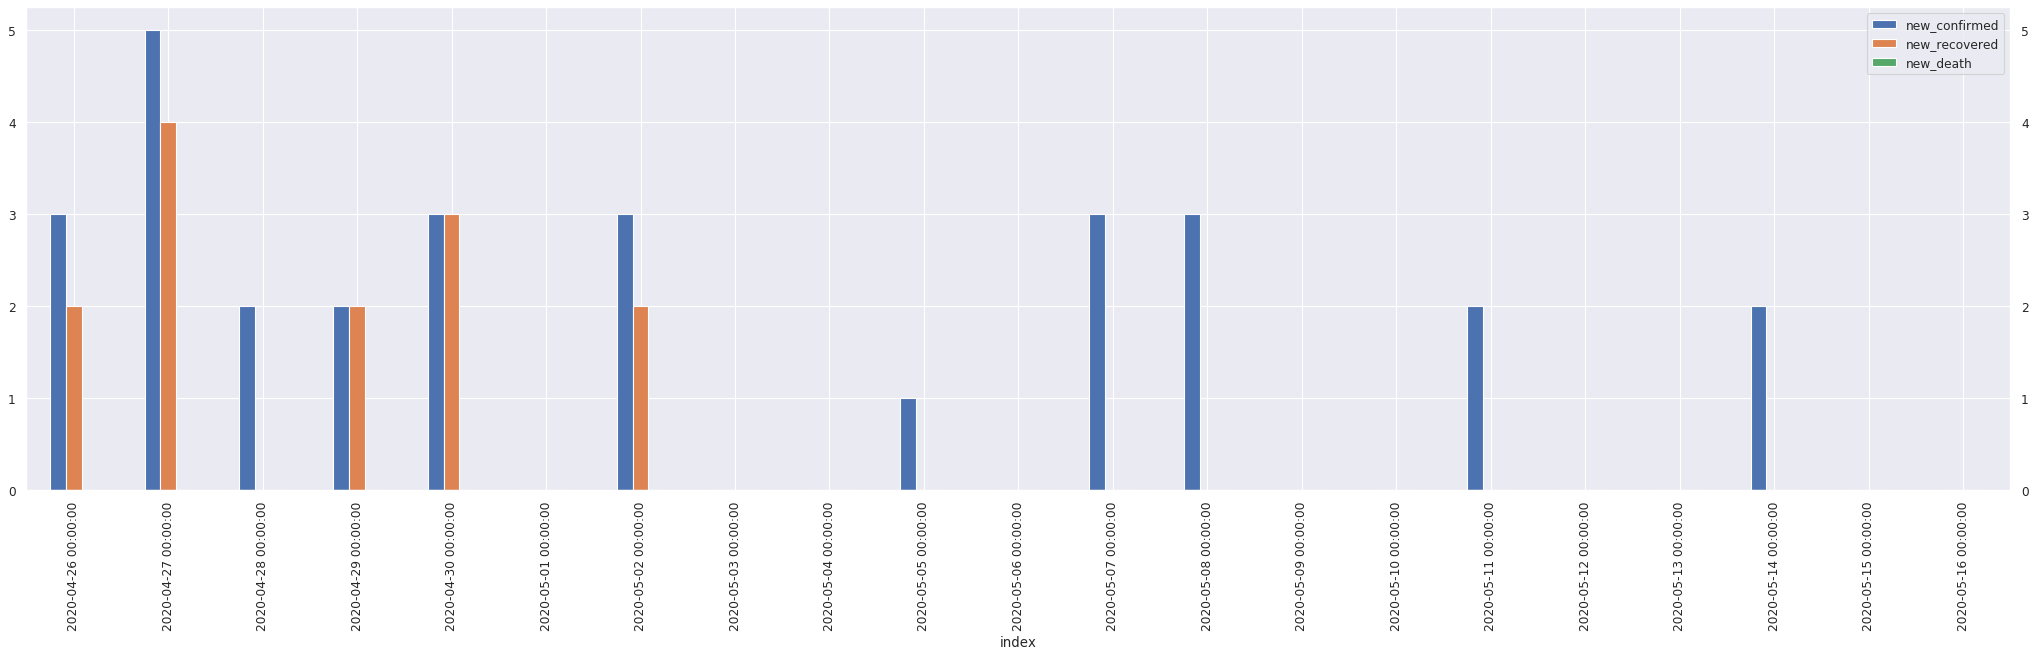

In [42]:
cbr_lk_regensburg.plot_daily_stats()

In [43]:
# --------------------------------------------------------------------------------------------------------------------------------



# --------------------------------------------------------------------------------------------------------------------------------

In [44]:
df = covid19.get_rki_df(time_anchor_column_name='Meldedatum')
cbr_germany2 = covid19.CasesByRegion('Germany', df=df)
cbr_germany2.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-12,171864,153305,7633,834,73,123
2020-05-13,172746,153338,7732,882,33,99
2020-05-14,173524,153368,7812,778,30,80
2020-05-15,174078,153375,7895,554,7,83
2020-05-16,174321,153379,7935,243,4,40


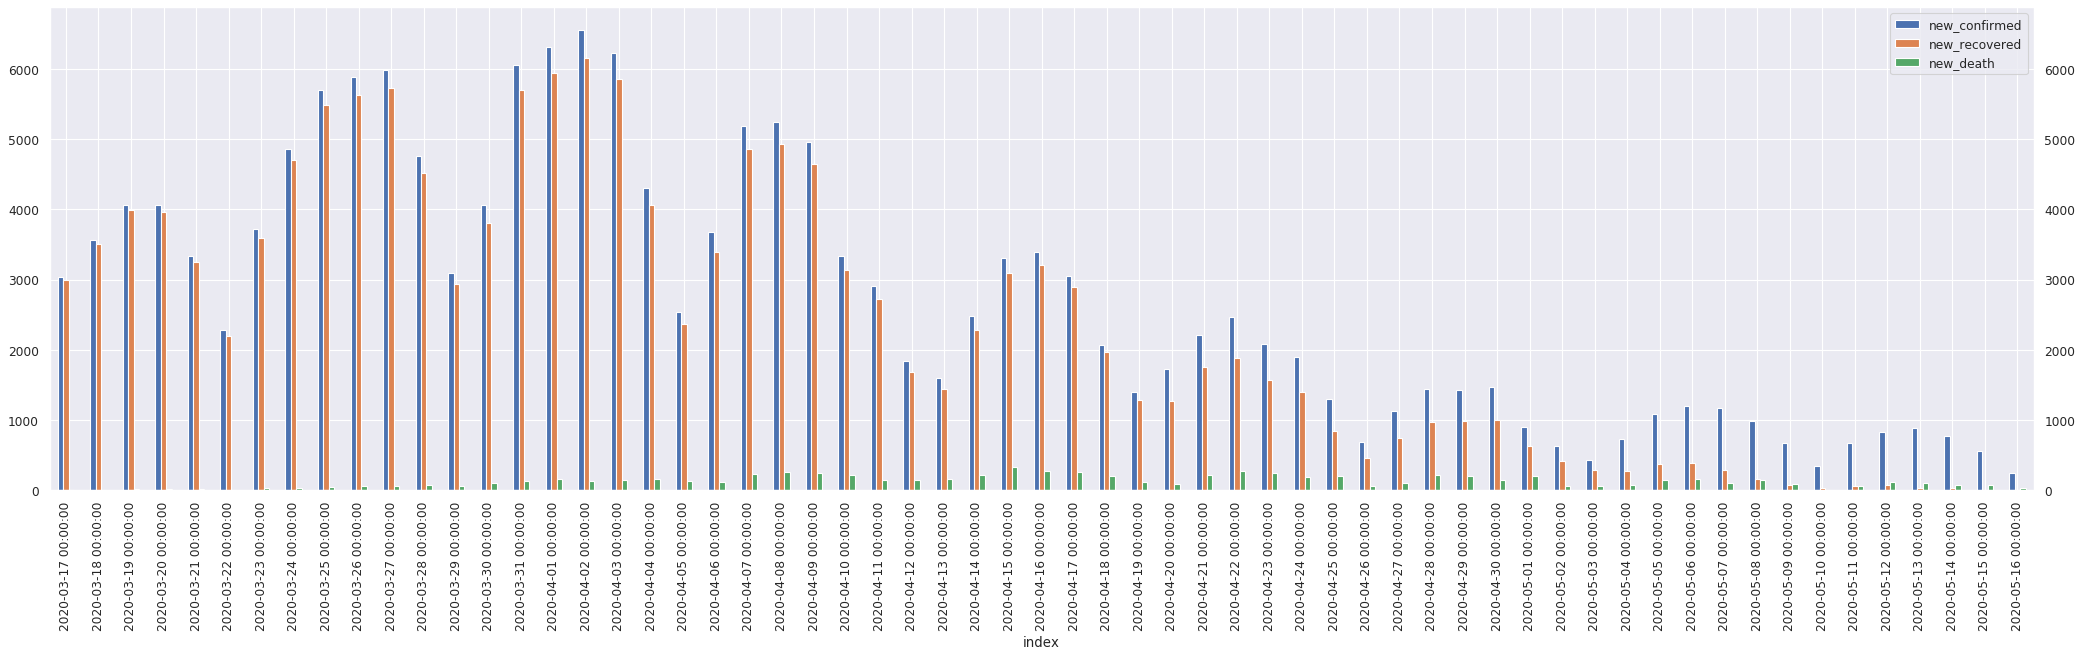

In [45]:
cbr_germany2.plot_daily_stats(days=60)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 809.1443539976424; growth-rate: 0.004, date:2020-06-24 00:00:00, projected value: 605.3198583574093


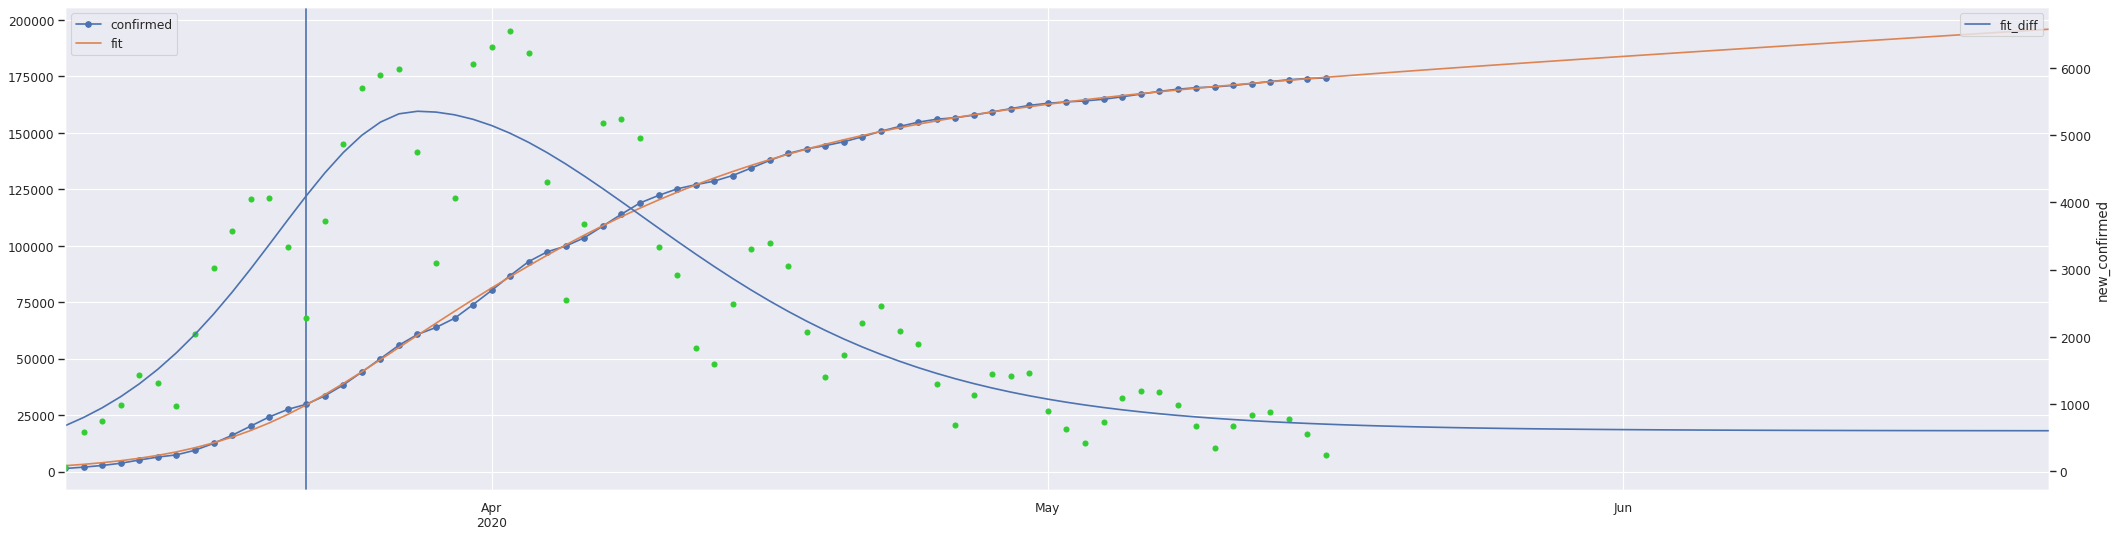

In [46]:
cbr_germany2.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany2.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [47]:
cbr_germany2.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5355.892523


In [48]:
cbr_germany2.calculate_R_estimates()
cbr_germany2.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-14,0.834,0.71,0.518,0.652,0.732


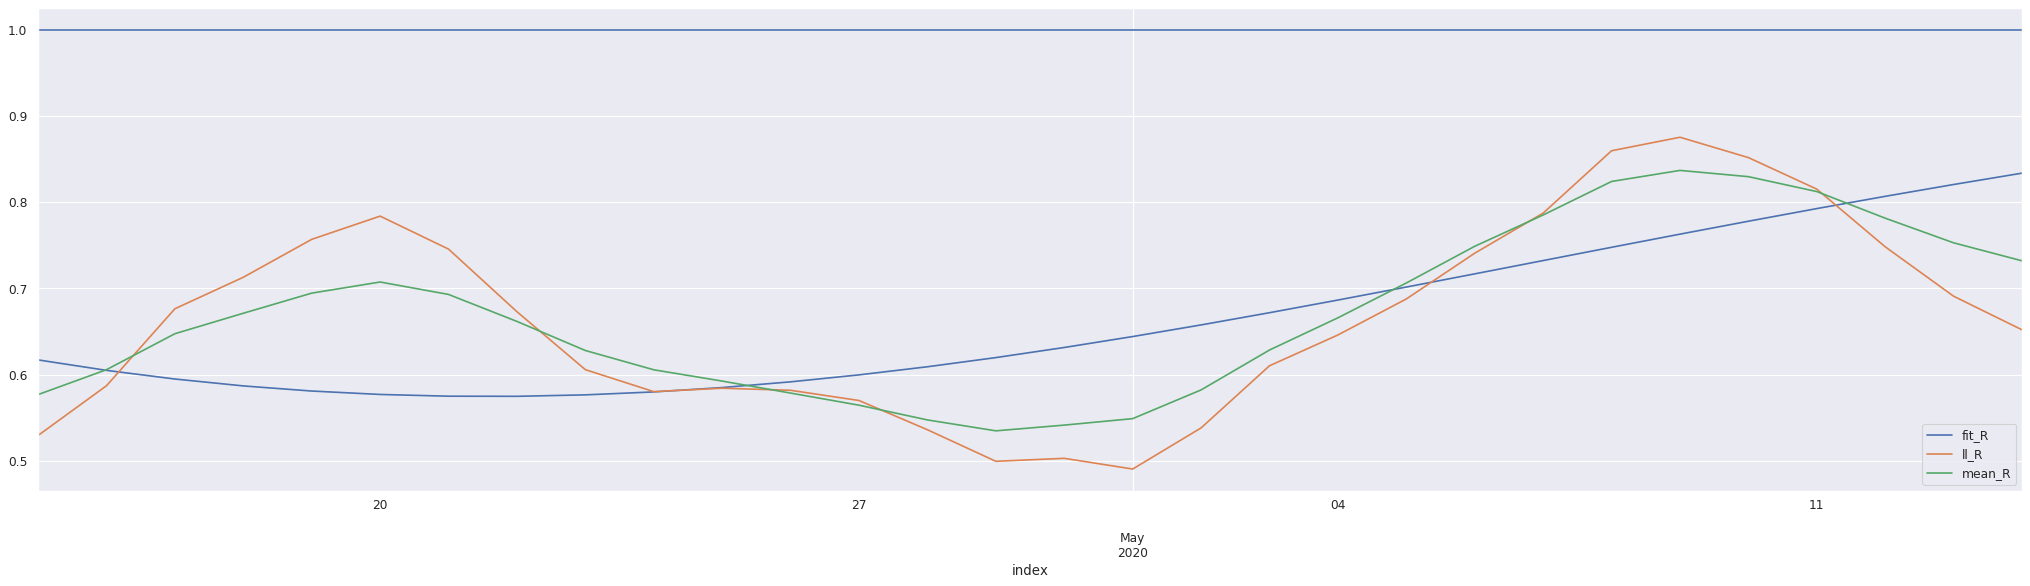

In [49]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany2.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [50]:
cbr_germany3 = covid19.CasesByRegion('Germany')
cbr_germany3.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-12,171150,147298,7633,732,1681,123
2020-05-13,172094,148700,7732,944,1402,99
2020-05-14,172961,150300,7812,867,1600,80
2020-05-15,173716,151597,7895,755,1297,83
2020-05-16,174304,152600,7935,588,1003,40


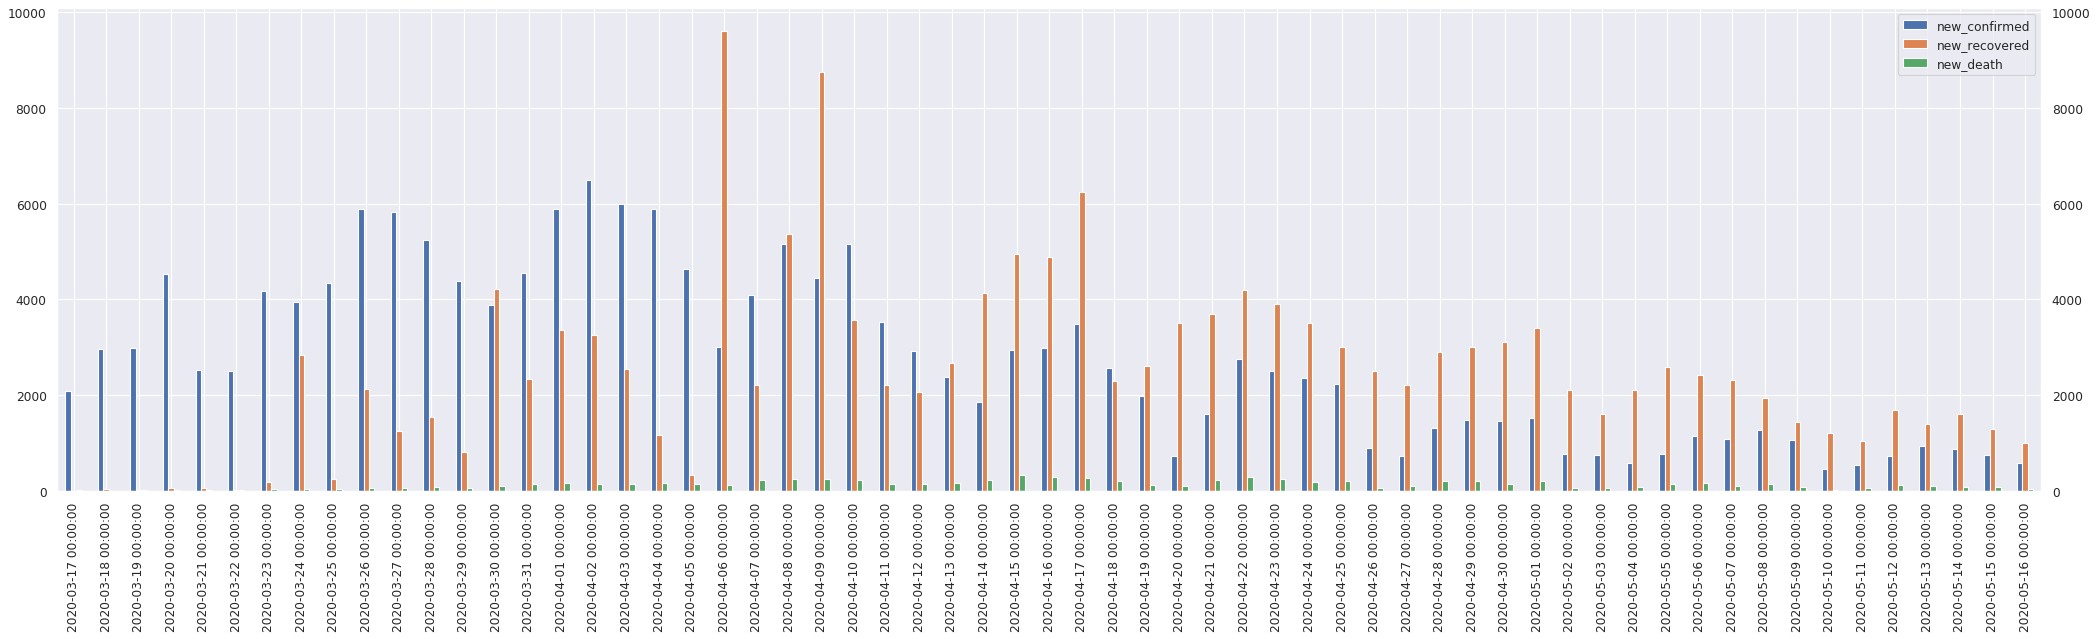

In [51]:
cbr_germany3.plot_daily_stats(days=60)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 701.802761257422; growth-rate: 0.004, date:2020-06-24 00:00:00, projected value: 642.2718537577754


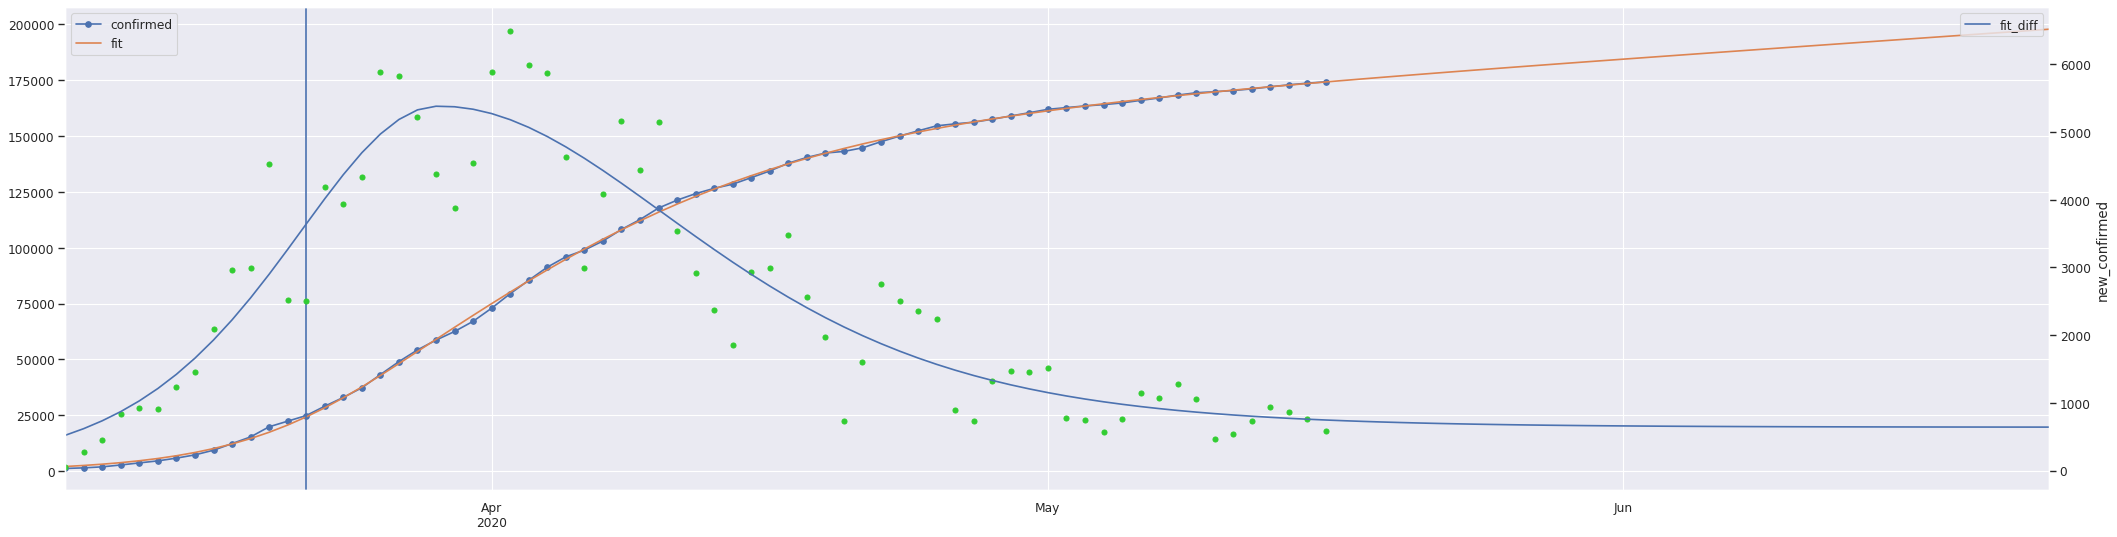

In [52]:
cbr_germany3.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany3.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [53]:
cbr_germany3.calculate_R_estimates()
cbr_germany3.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-14,0.83,0.835,0.787,0.798,0.821


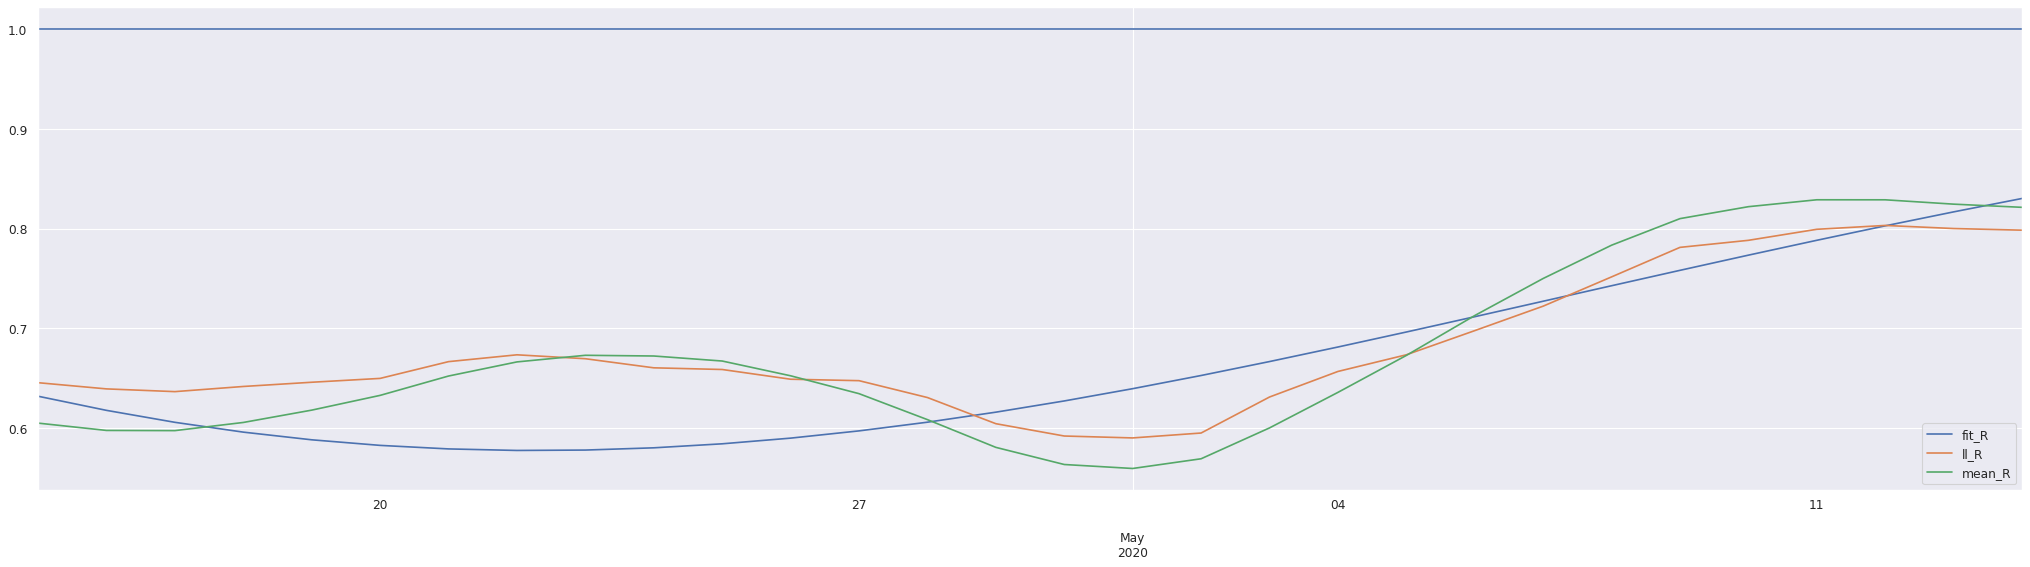

In [54]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany3.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [55]:
import requests

In [56]:
# https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting.html
# rki_nowcasting_data_url = 'https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting_Zahlen.xlsx'
rki_nowcasting_data_url = 'https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting_Zahlen.xlsx?__blob=publicationFile'

r = requests.get(rki_nowcasting_data_url, allow_redirects=True)  # to get content after redirection
# r.url, r.content
xd = pd.ExcelFile(r.content)
rki_nowcasting_df_ = xd.parse(xd.sheet_names[-1])
rki_nowcasting_df_.to_excel("rki_nowcasting_data.xlsx") 
rki_nowcasting_df_.tail()

,Datum des Erkrankungsbeginns,Punktschätzer der Anzahl Neuerkrankungen (ohne Glättung),Untere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen (ohne Glä,Obere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen (ohne Glät,Punktschätzer der Anzahl Neuerkrankungen,Untere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen,Obere Grenze des 95%-Prädiktionsintervalls der Anzahl Neuerkrankungen,Punktschätzer der Reproduktionszahl R,Untere Grenze des 95%-Prädiktionsintervalls der Reproduktionszahl R,Obere Grenze des 95%-Prädiktionsintervalls der Reproduktionszahl R,Punktschätzer des 7-Tage-R Wertes,Untere Grenze des 95%-Prädiktionsintervalls des 7-Tage-R Wertes,Obere Grenze des 95%-Prädiktionsintervalls des 7-Tage-R Wertes
67,2020-05-08,677,537,800,763,653,875,0.94,0.87,1.05,0.91,0.87,0.96
68,2020-05-09,625,514,793,709,593,841,0.86,0.79,0.95,0.89,0.84,0.94
69,2020-05-10,563,421,702,650,526,788,0.78,0.70,0.87,0.88,0.82,0.96
70,2020-05-11,729,466,987,648,484,821,0.79,0.68,0.92,0.89,0.81,0.97
71,2020-05-12,752,499,1036,667,475,880,0.88,0.72,1.05,NaN,NaN,NaN


In [57]:
rki_nowcasting_df = rki_nowcasting_df_[['Datum des Erkrankungsbeginns', 'Punktschätzer der Anzahl Neuerkrankungen (ohne Glättung)', 'Punktschätzer der Anzahl Neuerkrankungen']].copy()
rki_nowcasting_df.columns = ['index', 'new_confirmed', 'new_confirmed_']
rki_nowcasting_df['index'] = pd.to_datetime(rki_nowcasting_df['index'])
rki_nowcasting_df = rki_nowcasting_df.set_index('index')

last_date = rki_nowcasting_df.index[-1] + pd.DateOffset(days=1)
last_value = cbr_germany.df['confirmed'].loc[last_date]
# last_date, last_value

ldf = pd.DataFrame(index=rki_nowcasting_df.index)
ldf['confirmed'] = last_value - rki_nowcasting_df['new_confirmed'].values[::-1].cumsum()[::-1]
ldf.loc[last_date] = [last_value]
ldf['recovered'] = 0
ldf['death']     = 0
ldf['new_confirmed'] = covid19.discrete_diff(ldf['confirmed'])
ldf['new_recovered'] = covid19.discrete_diff(ldf['recovered'])
ldf['new_death']     = covid19.discrete_diff(ldf['death'])

rki_nowcasting_df = ldf.copy()

cbr_germany4 = covid19.CasesByRegion('Germany', df=rki_nowcasting_df)
cbr_germany4.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-09,170599,0,0,677.0,0.0,0.0
2020-05-10,171224,0,0,625.0,0.0,0.0
2020-05-11,171787,0,0,563.0,0.0,0.0
2020-05-12,172516,0,0,729.0,0.0,0.0
2020-05-13,173268,0,0,752.0,0.0,0.0


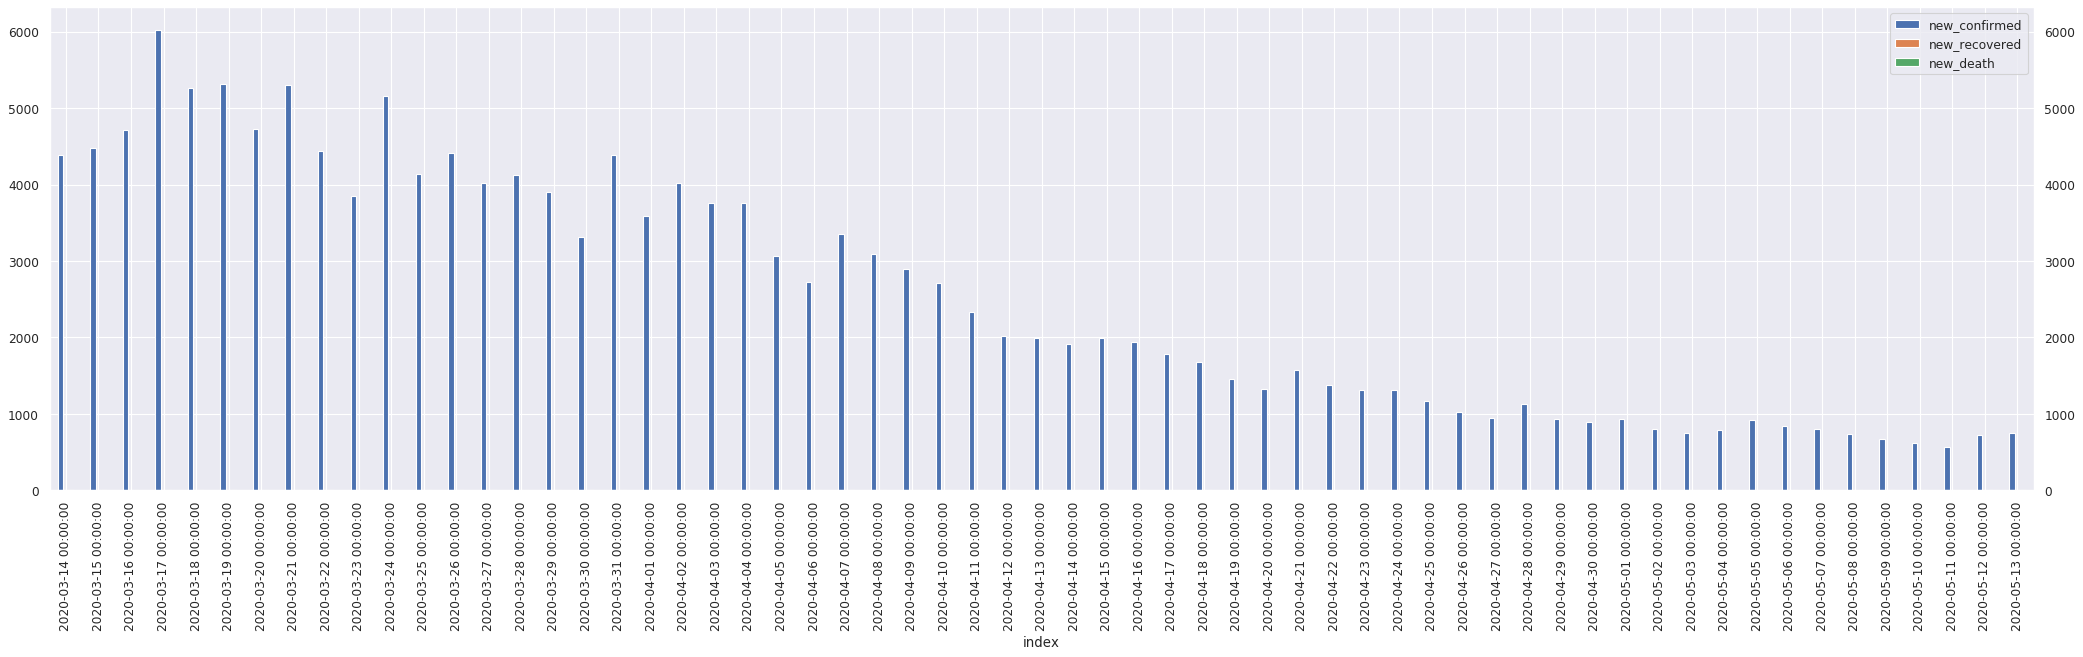

In [58]:
cbr_germany4.plot_daily_stats(days=60)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1517: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 325.81041603204653; growth-rate: 0.003, date:2020-06-21 00:00:00, projected value: 298.8283168060352


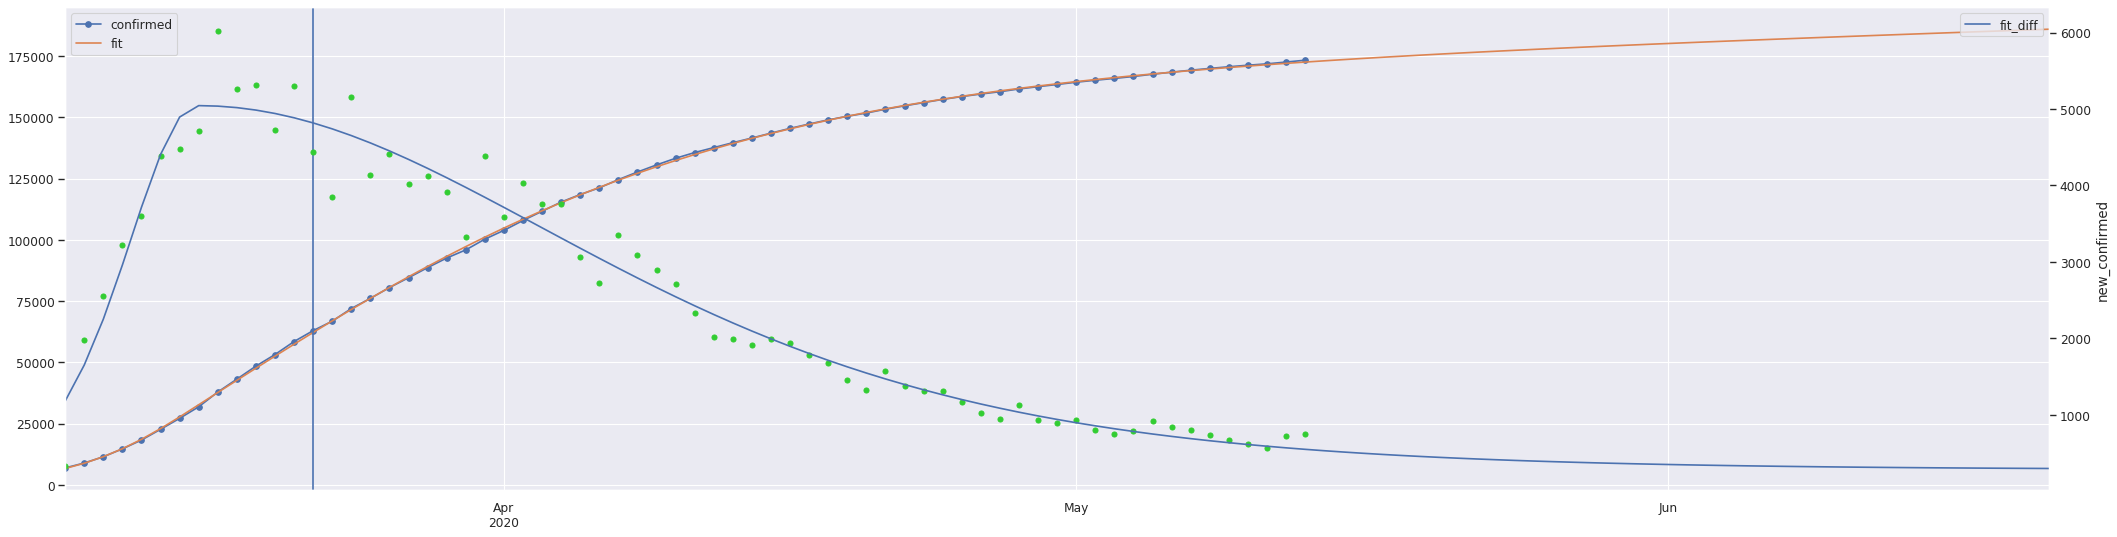

In [59]:
cbr_germany4.fit(first_date=pd.to_datetime('2020-03-09'))
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany4.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [60]:
cbr_germany4.calculate_R_estimates()
cbr_germany4.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-11,0.721,0.767,0.727,0.709,0.732


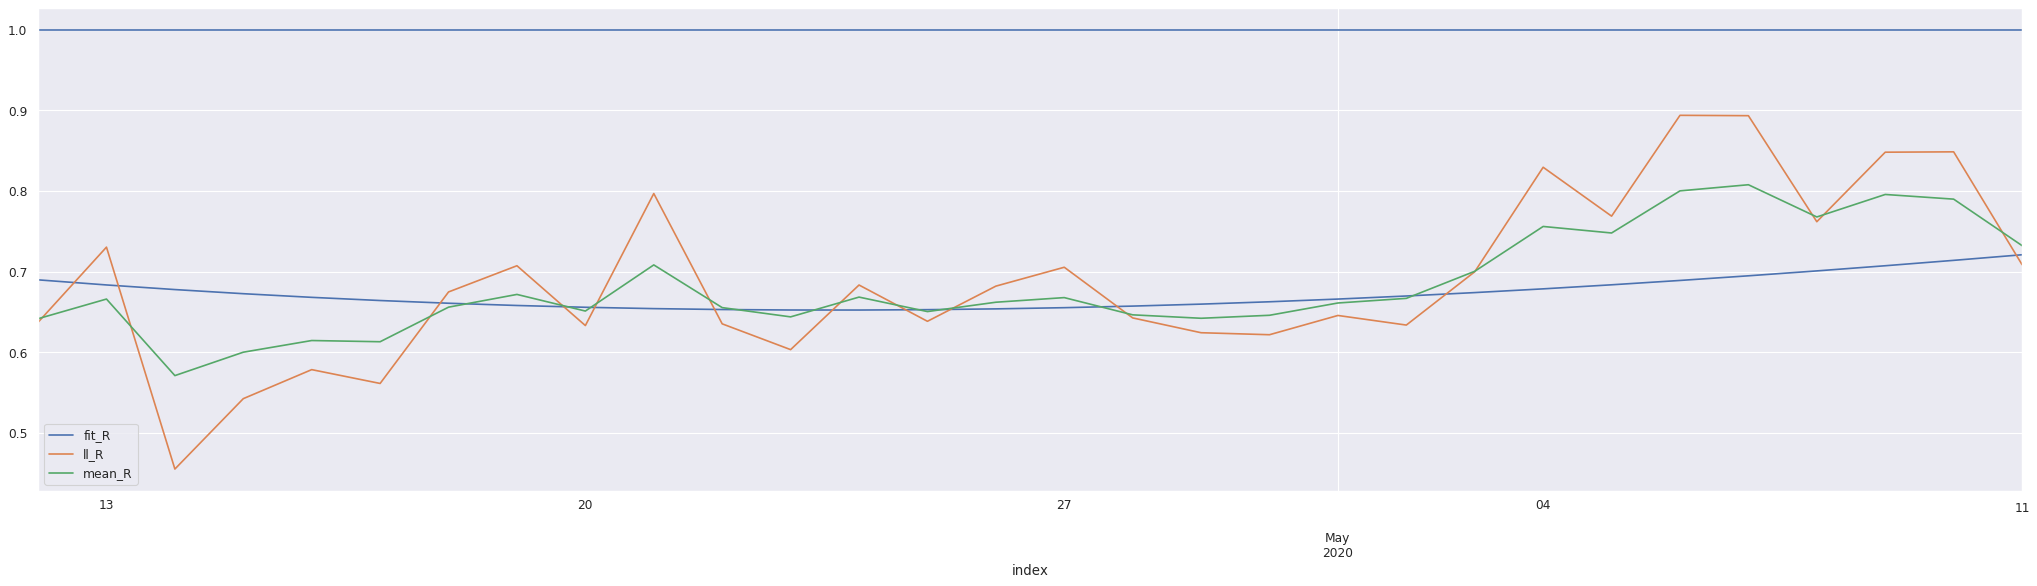

In [61]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany4.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [62]:
ldf = cbr_germany.df.loc[cbr_germany4.df.index, ['new_confirmed']]
ldf['new_confirmed_nc'] = cbr_germany4.df['new_confirmed']
ldf['delta'] = ldf['new_confirmed_nc'] - ldf['new_confirmed']
ldf = ldf.astype(np.int)
ldf.iloc[-30:]

,new_confirmed,new_confirmed_nc,delta
index,,,
2020-04-14,2106,1920,-186
2020-04-15,2287,1987,-300
2020-04-16,2211,1943,-268
2020-04-17,2247,1782,-465
2020-04-18,1649,1684,35
2020-04-19,1335,1461,126
2020-04-20,1638,1324,-314
2020-04-21,1567,1569,2
2020-04-22,1719,1375,-344
